## **Exploración de Sentencias - Corte Constitucional**

## **Importación de librerías**

In [1]:
import pandas as pd
import numpy as np

import tqdm
import os
import re

from multiprocessing import Pool

from sklearn.feature_extraction.text import CountVectorizer

import gensim


from gensim.test.utils import datapath
from gensim.models import FastText

import numpy as np

import nltk

from sklearn.metrics.pairwise import cosine_distances

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/caicardo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## **Definición de funciones**

In [3]:
def preprocessor(text):
    """
    preprocesador de texto
    """
    punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
    for char in punctuations:
        text = text.replace(char, " ")
    
    #     text = re.sub("[.,;\"\'?():-_`]", " ", text)
    text = re.sub("\s+", " ", text)
    text = text.lower()
    return text

In [4]:
def preprocessor_sentences(text):
    """
    preprocesador de texto con separación de frases por línea.
    """
    punctuations = '''!()-[]{};:'"\,<>/?@#$%^&*_~'''
    for char in punctuations:
        text = text.replace(char, " ")
    text = text.replace("\n\n", "<FIN>")
    text = text.replace(".", "<FIN>")
    text = re.sub("\s+", " ", text)
    text = text.replace("<FIN>", "\n")
    text = "".join([c for c in text if str.isprintable(c) or c=="\n" or c=="."])
    text = re.sub("[\n\r]+", "\n", text)
    text = text.lower()
    text = text.strip("\n ")
    return text

In [5]:
def wv_vectorizer(text):
    """
    Calcula el vector promedio de las palabras de la frase.
    """
    text = preprocessor(text)
    vec_list = []
    for word in [w for w in text.split() if w not in es_stopwords]:
        vec_list.append(model.wv[word])
    vec_list = np.array(vec_list)
    vec = np.mean(vec_list, axis=0)
    return vec

## **Configuración**

In [6]:
RANDOM_STATE = 42
N_TOP_DOCS = 5
CARACTERES = 500

In [7]:
es_stopwords = nltk.corpus.stopwords.words("spanish")

In [8]:
es_stopwords.remove("no")

## **Lectura de datos**

In [9]:
df = pd.read_csv("documents_pp.csv")

In [10]:
df.columns

Index(['Unnamed: 0', 'INDEX', 'LINK', 'DOCUMENT', 'tipo', 'pp'], dtype='object')

In [11]:
df["tipo"] = [x.strip()[0] for x in df.INDEX]

In [12]:
df.head()

,Unnamed: 0,INDEX,LINK,DOCUMENT,tipo,pp
0,0,A107-21,https://www.corteconstitucional.gov.co/Relator...,\nAuto 107/21\n \n \nReferencia: Expediente T-...,A,auto 107 21 referencia expediente t 7 909 170...
1,1,A106-21,https://www.corteconstitucional.gov.co/Relator...,\nAuto 106/21\n \n \nReferencia: Expediente T-...,A,auto 106 21 referencia expediente t 6 839 494...
2,2,A092-21,https://www.corteconstitucional.gov.co/Relator...,\nAuto 092/21\n \n \nReferencia: respuesta a l...,A,auto 092 21 referencia respuesta a la solicit...
3,3,A091-21,https://www.corteconstitucional.gov.co/Relator...,\nAuto 091/21\n \n \nReferencia: requerimiento...,A,auto 091 21 referencia requerimiento al minis...
4,4,A090-21,https://www.corteconstitucional.gov.co/Relator...,\nAuto 090/21\n \n \nReferencia: Expediente T-...,A,auto 090 21 referencia expediente t 7 185 421...


In [13]:
df.tipo.value_counts()

T    19190
A     8937
C     6874
S      371
s       24
t       16
c        7
E        2
Name: tipo, dtype: int64

## **Preprocesamiento de texto (para TF-IDF)**

No es necesario volver a preprocesar los datos, se deja el código para referencia y replicación

In [19]:
%%time
with Pool(8) as my_pool:
    pp_list = my_pool.map(preprocessor, df.DOCUMENT.values)

In [21]:
df["pp"] = pp_list

In [22]:
df.head()

,INDEX,LINK,DOCUMENT,tipo,pp
0,A107-21,https://www.corteconstitucional.gov.co/Relator...,\nAuto 107/21\n \n \nReferencia: Expediente T-...,A,auto 107 21 referencia expediente t 7 909 170...
1,A106-21,https://www.corteconstitucional.gov.co/Relator...,\nAuto 106/21\n \n \nReferencia: Expediente T-...,A,auto 106 21 referencia expediente t 6 839 494...
2,A092-21,https://www.corteconstitucional.gov.co/Relator...,\nAuto 092/21\n \n \nReferencia: respuesta a l...,A,auto 092 21 referencia respuesta a la solicit...
3,A091-21,https://www.corteconstitucional.gov.co/Relator...,\nAuto 091/21\n \n \nReferencia: requerimiento...,A,auto 091 21 referencia requerimiento al minis...
4,A090-21,https://www.corteconstitucional.gov.co/Relator...,\nAuto 090/21\n \n \nReferencia: Expediente T-...,A,auto 090 21 referencia expediente t 7 185 421...


**Guardar datos preprocesados**

In [23]:
df.to_csv("documents_pp.csv")

In [24]:
# Ejemplo
df.iloc[0].pp

' auto 107 21 referencia expediente t 7 909 170 ac acción de tutela promovida por carmen alicia rodríguez berrío y otros contra holding inmobiliaria y otros asunto solicitud de cumplimiento de la sentencia t 020 de 2021 peticionaria carmen alicia rodríguez berrío magistrada sustanciadora gloria stella ortiz delgado bogotá d c nueve 9 de marzo de dos mil veintiuno 2021 la suscrita magistrada sustanciadora en ejercicio de sus competencias constitucionales y legales profiere el presente auto con fundamento en los siguientes antecedentes 1 el pasado 27 de enero la sala sexta de revisión profirió la sentencia t 020 de 2021 1 en el caso particular de la señora carmen alicia dicha providencia concedió el amparo de los derechos a la estabilidad laboral reforzada y al mínimo vital 2 en consecuencia esta corporación le ordenó a holding inmobiliaria reintegrar a la peticionaria al trabajo que desempeñaba en la empresa lo anterior porque declaró ineficaz el despido además le ordenó reconocerle la 

**Prueba Segmentación por frases**

In [42]:
for i, frase in enumerate([frase for frase in preprocessor_sentences(df.iloc[0].DOCUMENT).split("\n")]):
    print("{0}. {1}".format(i, frase))

0. auto 107 21 referencia expediente t 7
1. 909
2. 170 ac
3.  acción de tutela promovida por carmen alicia rodríguez berrío y otros contra holding inmobiliaria y otros
4.  asunto solicitud de cumplimiento de la sentencia t 020 de 2021
5.  peticionaria carmen alicia rodríguez berrío
6.  magistrada sustanciadora gloria stella ortiz delgado
7.  bogotá d
8. c
9.  nueve 9 de marzo de dos mil veintiuno 2021 
10.  la suscrita magistrada sustanciadora en ejercicio de sus competencias constitucionales y legales profiere el presente auto con fundamento en los siguientes antecedentes 1
11.  el pasado 27 de enero la sala sexta de revisión profirió la sentencia t 020 de 2021 1 
12.  en el caso particular de la señora carmen alicia dicha providencia concedió el amparo de los derechos a la estabilidad laboral reforzada y al mínimo vital
13.  2
14.  en consecuencia esta corporación le ordenó a holding inmobiliaria reintegrar a la peticionaria al trabajo que desempeñaba en la empresa
15.  lo anterior p

**Guardar Corpus de documentos segmentados por frase**

In [43]:
with open("corpus_cc.txt", "w") as file:
    for doc in df.DOCUMENT.values:
        file.write(preprocessor_sentences(doc))
        file.write("\n")

## **Entrenamiento de vectores de palabras**

No es necesario entrenar el modelo con el corpus cada vez que se ejecute el libro, pasar a "cargar modelo"

In [ ]:
carpeta = os.getcwd()
direccion_corpus = os.path.join(carpeta, 'corpus_cc.txt')

In [48]:
corpus_file = datapath(direccion_corpus)         # absolute path to corpus
model = FastText(size=100, 
                 window=5, 
                 min_count=5, 
                 workers=-1, 
                 seed=RANDOM_STATE)
model.build_vocab(corpus_file=corpus_file)      # scan over corpus to build the vocabulary
total_words = model.corpus_total_words          # number of words in the corpus
model.train(corpus_file=corpus_file, total_words=total_words, epochs=5)

**Guardar modelo** 

In [78]:
model.save("modelo_cc.vec")

**Cargar modelo**

In [14]:
model = FastText.load("modelo_cc.vec")

## **Calcular vectores de las frases y los documentos**

**Entrenar vectores de documentos**

In [15]:
%%time
with Pool(8) as libreypool:
    vectors = libreypool.map(wv_vectorizer, df.pp.values)

df["vec"] = vectors

CPU times: user 3.3 s, sys: 3.32 s, total: 6.62 s
Wall time: 11min 17s


In [21]:
doc_vectors = np.array([x for x in df.vec.values])

**Guardar documentos con vectores**

In [16]:
df.to_csv("documents_vectors.csv")

**Cálculo de vector de la frase**

In [22]:
frase = "Deberes y atribuciones del juez para obtener la prueba genética ADN"

In [23]:
# calcular el vector de la frase
phrase_vec = wv_vectorizer(frase)

In [24]:
# Calcular distancia de la frase a los documentos
distances = cosine_distances(phrase_vec.reshape(1, -1), doc_vectors)

In [25]:
distances = distances.flatten()

In [26]:
top_docs = np.argsort(distances, )[:N_TOP_DOCS]

In [27]:
for i, doc in enumerate(zip(df.iloc[top_docs].DOCUMENT, df.iloc[top_docs].INDEX)):
    print(f"{i+1}. {doc[1]}:\n{doc[0][:CARACTERES]}")
    print("-"*70)

1.  C-476-05:
 


REPUBLICA DE COLOMBIA


Sentencia C-476/05
 
DERECHO AL RECONOCIMIENTO DE LA PERSONALIDAD JURIDICA-Guarda estrecha relación con el derecho a la igualdad/ESTADO
CIVIL DE LAS PERSONAS-Determina la situación de una persona en la familia y
en la sociedad y de él se derivan derechos y obligaciones que se regulan por la
ley civil
 
Conforme a lo dispuesto por el artículo 14 de la Constitución
Política toda persona tiene derecho al reconocimiento de su personalidad
jurídica, lo cual se hace in
----------------------------------------------------------------------
2.  C-860-08:
 


Referencia: expedientes D-xxx, D-xxx y D-xxx (acumulados)


SENTENCIA C-860/08
 (Bogotá
D.C. septiembre 3)
 
PRINCIPIO DE INMEDIACION EN PROCESO DE FILIACION-Importancia
 
Por regla
general, la prueba, o la parte de ella que no dependa del dictamen de un
experto, debe practicarse en presencia del funcionario investido por la
Constitución y la ley de funciones judiciales, que es quien ha de valorar 

## **Búsqueda Literal**

In [32]:
busqueda = "ADN"

In [33]:
df_tmp = df[df.pp.str.contains(busqueda.lower())].head(N_TOP_DOCS)

for i, doc in enumerate(zip(df_tmp.DOCUMENT, df_tmp.INDEX)):
    print(f"{i+1}. {doc[1]}:\n{doc[0][:CARACTERES]}")
    print("-"*70)

1.  A338-20:

Auto 338/20
 
 
Referencia: Solicitudes de nulidad
formuladas por: (i) la empresa Carbones del Cerrejón Limited; y, (ii) Mary Luz
Uriana Ipuana y Yasmina Uriana, integrantes del Resguardo Indígena Provincial,
contra la Sentencia T-614 de 2019.
 
Expediente: T-6.518.300. Acción
de tutela formulada por Mary Luz Uriana Ipuana y Yasmina Uriana, integrantes
del Resguardo Indígena Provincial, contra la empresa Carbones del
Cerrejón Limited, el Ministerio de Ambiente y Desarrollo Sostenible, el

----------------------------------------------------------------------
2.  A387-19:

Auto 387/19
 
 
Asunto: Verificación de cumplimiento de
órdenes proferidas en la Sentencia T-236 del 21 de abril de 2017.
 
Magistrado Sustanciador:
ALBERTO ROJAS RÍOS
 
 
Bogotá D.C., dieciocho (18) de julio de
dos mil diecinueve (2019)
 
 
La Sala Plena de la Corte Constitucional
integrada por las Magistradas Gloria Stella Ortiz Delgado, quién la preside y
Diana Fajardo Rivera, al igual que los Magistr

## **[EN CONSTRUCCIÓN] Análisis de frecuencia de palabras**

In [120]:
df["palabras"] = [len(doc.split()) for doc in df.pp.values]

In [121]:
import matplotlib.pyplot as plt

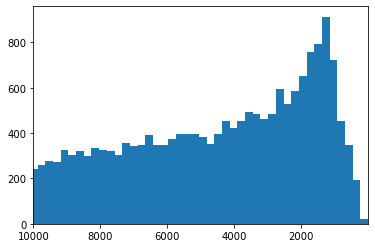

In [137]:
fig, ax = plt.subplots(1,1)
# fig.set_figheight(15)
# fig.set_figwidth(15)
# # ax.set_size_inches(10,15)
ax.set_xlim(10000)
ax.rev
ax.hist(df.palabras.values, bins=10000)

# data['pm2.5'].hist(bins=1000,grid=False)
# ax.set_xlabel("Palabras", fontsize=15)
# ax.set_ylabel("Documentos",fontsize=15)
plt.show()

In [139]:
np.argmax(df.palabras.values)

33328

In [145]:
print(df.iloc[np.argmax(df.palabras.values)].LINK)

https://www.corteconstitucional.gov.co/Relatoria/1996/C-037-96.htm


In [146]:
from bs4 import BeautifulSoup

In [148]:
main_soup = BeautifulSoup(df.iloc[np.argmax(df.palabras.values)].DOCUMENT, 'lxml')

In [149]:
main_soup.text

'LEY ESTATUTARIA JUSTICIA\n\n\n'

In [150]:
with open("sentencia_sucia.txt", "w") as f:
    f.write(df.iloc[np.argmax(df.palabras.values)].DOCUMENT)